In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from pystk2_gymnasium import AgentSpec
from pystk2_gymnasium.envs import STKRaceEnv
from pystk2_gymnasium.stk_wrappers import ConstantSizedObservations, DiscreteActionsWrapper
from pystk2_gymnasium.wrappers import FlattenerWrapper, SpaceFlattener
from pystk2_gymnasium.definitions import ActionObservationWrapper

import gymnasium as gym
from pystk2_gymnasium import AgentSpec
from tqdm import tqdm
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import clear_output

from utils.custom_wrappers import ActionTimeExtentionWrapper, EscapeStuckObservationWrapper, ExpertObservationWrapper
from utils.experts import ExpertAgent1, ExpertAgent2, ExpertAgent3

device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [40]:
continuous_vars = ['karts_position', 'previous_actions', 'velocity', 'start_race', 'obstacle_ahead', 'obstacle_position', 'target_position', 'target_angle', 'target_distance', 'powerup']

def state_to_tensor(state):

    continuous_state = []
    for key in continuous_vars:
        value = state[key]
        if value.shape:
            num_envs = value.shape[0]
            if key in ['items_position', 'paths_end', 'paths_start', 'paths_width']:
                normalized_value = value[..., :10, :]
            else:    
                # normalized_value = (value - self.means[key]) / self.stds[key]
                normalized_value = value
            
            # print(key, normalized_value.reshape(num_envs, -1).shape)
            continuous_state.append(normalized_value.reshape(num_envs, -1))

    continuous_state = np.concatenate(continuous_state, axis=-1)
    state = torch.tensor(continuous_state, dtype=torch.float32)

    return state

In [41]:
class MLPWithMultipleHeads(nn.Module):
    def __init__(self, input_dim, hidden_dim, discrete_dims, continuous_dims):
        super(MLPWithMultipleHeads, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.discrete_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, out_dim),
            )
            for out_dim in discrete_dims
        ])
        self.continuous_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, out_dim),
                nn.Sigmoid() if i == 0 else nn.Identity()
            )
            for i, out_dim in enumerate(continuous_dims)
        ])
        

    def forward(self, x):
        shared_output = self.shared_layers(x)
        continuous_action = torch.stack([head(shared_output) for head in self.continuous_heads], dim=1)
        discrete_action = torch.stack([head(shared_output) for head in self.discrete_heads], dim=1)
        
        return {
            'continuous': continuous_action.squeeze(-1),
            'discrete': discrete_action,
        }

In [42]:
class ActionOnlyFlattenerWrapper(ActionObservationWrapper):
    """Flattens actions and observations."""

    def __init__(self, env: gym.Env):
        super().__init__(env)

        self.action_flattener = SpaceFlattener(env.action_space)
        self.action_space = self.action_flattener.space
        
    def observation(self, observation):
        return observation


    def action(self, action):
        discrete_actions = {}
        if not self.action_flattener.only_continuous:
            actions = (
                action if self.action_flattener.only_discrete else action["discrete"]
            )
            assert len(self.action_flattener.discrete_keys) == len(actions), (
                "Not enough discrete values: "
                f"""expected {len(self.action_flattener.discrete_keys)}, """
                f"""got {len(action)}"""
            )
            discrete_actions = {
                key: key_action
                for key, key_action in zip(self.action_flattener.discrete_keys, actions)
            }

        continuous_actions = {}
        if not self.action_flattener.only_discrete:
            actions = (
                action
                if self.action_flattener.only_continuous
                else action["continuous"]
            )
            continuous_actions = {
                key: actions[
                    self.action_flattener.indices[ix] : self.action_flattener.indices[
                        ix + 1
                    ]
                ].reshape(shape)
                for ix, (key, shape) in enumerate(
                    zip(
                        self.action_flattener.continuous_keys,
                        self.action_flattener.shapes,
                    )
                )
            }

        return {**discrete_actions, **continuous_actions}



In [43]:
def batch2frac(state):
    key = list(state.keys())[0]
    num_envs = state[key].shape[0]

    fractioned_state = [{} for _ in range(num_envs)]
    for i in range(num_envs):
        for key in state:
            fractioned_state[i][key] = state[key][i]
    
    return fractioned_state

def frac2batch(list):
    keys = list[0].keys()
    res = {key:[] for key in keys}
    for i in range(len(list)):
        for key in keys:
            res[key].append(list[i][key])
    
    for key in keys:
        if isinstance(res[key][0], torch.Tensor):
            res[key] = torch.stack(res[key])
        elif isinstance(res[key][0], np.ndarray):
            res[key] = torch.tensor(np.stack(res[key]))
        else:
            raise ValueError('WTH!!')
    
    return res

In [48]:
import random
from collections import defaultdict


    
attributes_dicts = {
    'speed':('continuous',0),
    'steer':('continuous',1),
    'brake':('discrete',0),
    'drift':('discrete',1),
    'fire':('discrete',2),
    'nitro':('discrete',3),
    'rescue':('discrete',4),
}

class FIFOReplayBuffer:
    def __init__(self, max_size=100000, num_bins=20):
        self.max_size = max_size
        self.buffer = []  # Stores (state, expert_action)
        self.num_bins = num_bins  # Used if first attribute is continuous

    def add(self, state, expert_action):
        # Add a new tuple to the buffer
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)  # Remove the oldest element
        self.buffer.append((state, expert_action))

    def sample(self, batch_size, attribute):
        if len(self.buffer) == 0:
            return []

        cat, idx = attributes_dicts[attribute]
        
        first_attributes = np.array([s[1][cat][idx] for s in self.buffer])  # Extract first attribute
        sampled_indices = []

        if np.issubdtype(type(first_attributes[0]), np.number):  # Continuous case
            bins = np.histogram_bin_edges(first_attributes, bins=self.num_bins)
            bin_indices = np.digitize(first_attributes, bins)  # Assign each value to a bin

        else:  # Categorical case
            bin_indices = first_attributes  # Treat as labels directly

        grouped_indices = defaultdict(list)
        for i, bin_idx in enumerate(bin_indices):
            grouped_indices[bin_idx].append(i)

        # Sample proportionally from each group
        for indices in grouped_indices.values():
            # num_samples = max(1, int(batch_size * (len(indices) / len(self.buffer))))
            num_samples = max(1, int(batch_size * 1 / len(grouped_indices)))
            sampled_indices.extend(random.sample(indices, min(num_samples, len(indices))))

        random.shuffle(sampled_indices)
        return [self.buffer[i] for i in sampled_indices]

    def __len__(self):
        return len(self.buffer)


In [49]:
num_envs = 8

def make_env():
    env = STKRaceEnv(agent=AgentSpec(use_ai=False), render_mode=None, num_kart=10, difficulty=2, laps=1)
    env = gym.wrappers.PassiveEnvChecker(env)
    env = gym.wrappers.OrderEnforcing(env)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=3000)
    env = ConstantSizedObservations(env, state_paths=20, state_items=5, state_karts=5)
    # env = DiscreteActionsWrapper(env)
    env = ActionOnlyFlattenerWrapper(env)
    env = ActionTimeExtentionWrapper(env, n=5)
    env = ExpertObservationWrapper(env)
    return env


from types import MethodType

def modified_get_state(self, kart_ix: int, use_ai: bool):
        kart = self.world.karts[kart_ix]
        terminated = kart.has_finished_race

        # Get the observation and update the world state
        obs = self.get_observation(kart_ix, use_ai)

        d_t = max(0, kart.overall_distance)
        f_t = 1 if terminated else 0
        reward = (
            (d_t - self.last_overall_distances[kart_ix]) / 10.0
            # + (1.0 - kart.position / self.num_kart) * (3 + 7 * f_t)
            # - 0.1
            # + 10 * f_t
        )
        return (
            obs,
            reward,
            terminated,
            {
                "position": kart.position,
                "distance": d_t,
            },
        )

def get_envs():
    env = gym.vector.SyncVectorEnv([
        lambda: make_env()
        for _ in range(num_envs)
    ])

    init_state, _ = env.reset()
    state = init_state

    for i in range(len(env.envs)):
        env.envs[i].unwrapped.get_state = MethodType(modified_get_state, env.envs[i].unwrapped)
    return env, state

In [50]:
model = MLPWithMultipleHeads(
    input_dim=64, #211, #64
    hidden_dim=512,
    discrete_dims=[2, 2, 2, 2, 2],
    continuous_dims=[1, 1]
).to(device)
# model.load_state_dict(torch.load('models/dagger3.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
continuous_criterion = nn.MSELoss() #nn.L1Loss()
discrete_criterion = nn.CrossEntropyLoss()

expert = ExpertAgent3()
replay_buffer = FIFOReplayBuffer(max_size=200000)

## Add PySTK expert trajectories to the replay_buffer:

In [51]:
# from collections import defaultdict
# import os

# paths = ['data/experts/Expert3_2025-01-26_14-59']

# expert_data = defaultdict(list)
# for folder in paths:
#     folder_listdir = os.listdir(folder)
#     folder_listdir = folder_listdir[:len(folder_listdir)//10]
#     for path in tqdm(folder_listdir):
#         loaded_data = np.load(f'{folder}/{path}')
#         loaded_data.allow_pickle = True
#         restored_dict = {key: loaded_data[key] for key in loaded_data}
#         for key in restored_dict:
#             expert_data[key].append(restored_dict[key])
            
# for key in expert_data:
#     expert_data[key] = np.concat(expert_data[key])


# expert_data_states = state_to_tensor(expert_data)

# for i in tqdm(range(len(expert_data['action']))):
#     x = expert_data['action'][i]
#     expert_action = {
#         'continuous': np.concatenate((x['acceleration'], x['steer'])),
#         'discrete': np.stack((x['brake'], x['drift'], x['fire'], x['nitro'], x['rescue']))  
#     }
#     replay_buffer.add(
#         state=expert_data_states[i],
#         expert_action=expert_action
#     )


## Training:

In [ ]:
env, state = get_envs()

losses = []
reg_losses = []
class_losses = []


total_steps = 0

epoch_tqdm = tqdm(range(2000))
for epoch in epoch_tqdm:
    
    
    # states, actions, expert_actions = [], [], []    
    
    for _ in range(100):
        
        # Expert action:
        fractioned_state = batch2frac(state)
        expert_action = {
            'continuous': np.zeros((num_envs, 2), dtype=np.float32),
            'discrete': np.zeros((num_envs, 5), dtype=np.float32)
        }
        for i in range(num_envs):
            action = expert.get_action(fractioned_state[i])
            expert_action['continuous'][i] = action['continuous']
            expert_action['discrete'][i] = action['discrete']
              
        
        tensor_state = state_to_tensor(state).to(device)
        
        if (total_steps // 50) % 2 == 0:
            # Model action:
            with torch.no_grad():
                pred_action = model(tensor_state)
                agent_action = {
                    'continuous': pred_action['continuous'].cpu(),
                    'discrete': pred_action['discrete'].argmax(-1).cpu()
                }
            next_state, reward, terminated, truncated, info = env.step(agent_action)
        
        else:
            next_state, reward, terminated, truncated, info = env.step(expert_action)
            
        total_steps += 1
        
        # Add to the reply buffer:
        expert_action = batch2frac(expert_action)
        for i in range(len(tensor_state)):
            # print((tensor_state[i].cpu() / 20) == expert_action[i]['continuous'][1])
            replay_buffer.add(tensor_state[i].cpu(), expert_action[i])

                    
        state = next_state
    
    
    for _ in range(10):
        for action_name in ['speed', 'speed', 'speed', 'speed', 'steer', 'fire', 'nitro']:
            
            samples = replay_buffer.sample(batch_size=512, attribute=action_name)
            states = torch.stack([samples[i][0] for i in range(len(samples))]).to(device)
            expert_actions = [samples[i][1] for i in range(len(samples))]
            expert_actions = frac2batch(expert_actions)
            expert_actions = expert_actions
                
            pred_action = model(states)

            error = 0
            reg_error = 0
            class_error = 0
            for action_type in ['continuous', 'discrete']:
            # action_type, action_idx = attributes_dicts[action_name]
                if action_type == 'continuous':
                    pred = pred_action['continuous'].cpu()
                    target = expert_actions['continuous'].cpu()
                    criterion = continuous_criterion
                    factor = 3
                    reg_error = criterion(pred, target)
                    reg_losses.append(reg_error.item())
                elif action_type == 'discrete':
                    pred = pred_action['discrete'].cpu().reshape(-1, 2)
                    target = expert_actions['discrete'].long().reshape(-1).cpu()
                    criterion = discrete_criterion
                    factor = 1
                    class_error = criterion(pred, target)
                    class_losses.append(class_error.item())
                
                error += factor*criterion(pred, target)
                
            loss = error
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
        
        
    
    # break
    
    if epoch % 1 == 0:
        clear_output(True)
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(losses)
        axs[0].set_ylim(0, 4)
        axs[1].plot(reg_losses)
        axs[1].set_ylim(0, 2)
        axs[2].plot(class_losses)
        axs[2].set_ylim(0, 2)

        plt.show()
        
    if epoch % 10 == 0:
        torch.save(model.state_dict(), 'models/dagger8.pt') 
        
    epoch_tqdm.set_description(f'Epoch: {epoch}  Buffer size: {len(replay_buffer)}')

## Distirbution of action values (comparaison between stratified and uniform sampling):

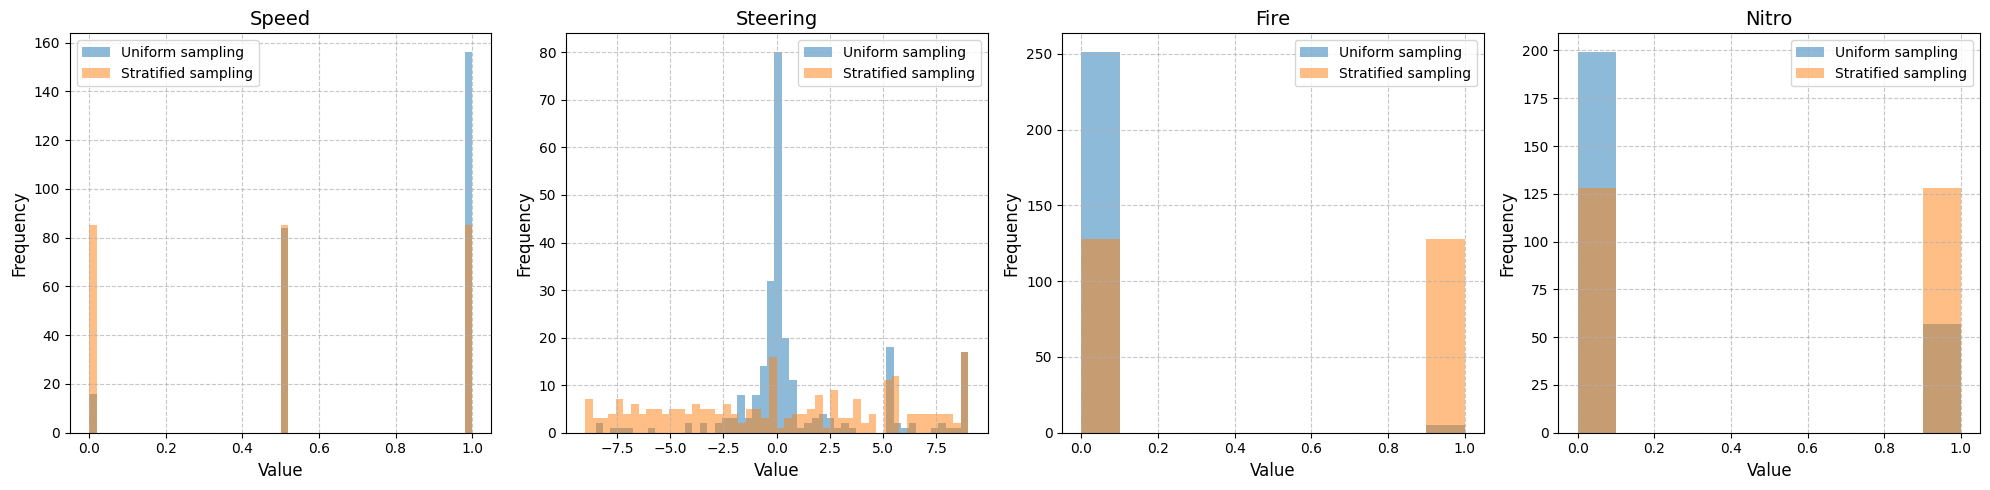

In [61]:
speed = [action['continuous'][0] for _, action in random.sample(replay_buffer.buffer, 256)]
steer = [action['continuous'][1] for _, action in random.sample(replay_buffer.buffer, 256)]
fire = [action['discrete'][2] for _, action in random.sample(replay_buffer.buffer, 256)]
nitro = [action['discrete'][3] for _, action in random.sample(replay_buffer.buffer, 256)]

speed_strat = [action['continuous'][0] for _, action in replay_buffer.sample(batch_size=256, attribute='speed')]
steer_strat = [action['continuous'][1] for _, action in replay_buffer.sample(batch_size=256, attribute='steer')]
fire_strat = [action['discrete'][2] for _, action in replay_buffer.sample(batch_size=256, attribute='fire')]
nitro_strat = [action['discrete'][3] for _, action in replay_buffer.sample(batch_size=256, attribute='nitro')]

fig, axs = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)
titles = ["Speed", "Steering", "Fire", "Nitro"]
bins = [50, 50, 10, 10]
colors = ['tab:orange', 'tab:blue']

data_strat = [speed_strat, steer_strat, fire_strat, nitro_strat]
data = [speed, steer, fire, nitro]

for i, ax in enumerate(axs):
    ax.hist(data[i], bins=bins[i], alpha=0.5, color=colors[1], label="Uniform sampling")
    ax.hist(data_strat[i], bins=bins[i], alpha=0.5, color=colors[0], label="Stratified sampling")
    
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel("Value", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()

plt.savefig('strat_vs_unif.pdf')
plt.show()

# Evaluation:

In [21]:
from time import sleep

def make_env():
    env = gym.make("supertuxkart/full-v0", render_mode="human", agent=AgentSpec(use_ai=False), num_kart=10, difficulty=2, laps=1, track=None)
    # env = STKRaceEnv(agent=AgentSpec(use_ai=False), render_mode="human", num_kart=6, difficulty=2, laps=1)
    env = gym.wrappers.PassiveEnvChecker(env)
    env = gym.wrappers.OrderEnforcing(env)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=10000)
    env = ConstantSizedObservations(env, state_paths=20, state_items=5, state_karts=5)
    # env = DiscreteActionsWrapper(env)
    env = ActionOnlyFlattenerWrapper(env)
    env = ActionTimeExtentionWrapper(env, n=5)
    env = ExpertObservationWrapper(env)
    return env
    
    
def eval():
    
    eval_env = gym.vector.SyncVectorEnv([lambda: make_env() for _ in range(1)])

    init_state, _ = eval_env.reset()
    state = init_state


    for step in range(10000):
        
        
        fractioned_state = batch2frac(state)
        action = {
            'continuous': np.zeros((num_envs, 2), dtype=np.float32),
            'discrete': np.zeros((num_envs, 5), dtype=np.float32)
        }
        for i in range(num_envs):
            action_ = expert.get_action(fractioned_state[i])
            action['continuous'][i] = action_['continuous']
            action['discrete'][i] = action_['discrete']    
        
        
        
        # Model action:
        # tensor_state = state_to_tensor(state).to(device)
        # with torch.no_grad():
        #     pred_action = model(tensor_state)
        #     action = {
        #         'continuous': pred_action['continuous'].cpu(),
        #         'discrete': pred_action['discrete'].argmax(-1).cpu()
        #     }

        print(action)
        next_state, reward, terminated, truncated, info = eval_env.step(action)
                    
        state = next_state
        sleep(0.02)

    eval_env.close()

In [ ]:
eval_env = gym.vector.SyncVectorEnv([lambda: make_env() for _ in range(1)])

init_state, _ = eval_env.reset()
state = init_state

eval_num_envs = 1

for step in range(10000):
    
    
    fractioned_state = batch2frac(state)
    expert_action = {
        'continuous': np.zeros((eval_num_envs, 2), dtype=np.float32),
        'discrete': np.zeros((eval_num_envs, 5), dtype=np.float32)
    }
    for i in range(eval_num_envs):
        action_ = expert.get_action(fractioned_state[i])
        expert_action['continuous'][i] = action_['continuous']
        expert_action['discrete'][i] = action_['discrete']    
    
    
    
    # Model action:
    tensor_state = state_to_tensor(state).to(device)
    with torch.no_grad():
        pred_action = model(tensor_state)
        action = {
            'continuous': pred_action['continuous'].cpu(),
            'discrete': pred_action['discrete'].argmax(-1).cpu()
        }

    # print(action)   
    # next_state, reward, terminated, truncated, info = eval_env.step(expert_action)
    next_state, reward, terminated, truncated, info = eval_env.step(action)

    state = next_state
    sleep(0.02)

eval_env.close()

In [ ]:
eval_env.close()